In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from pyproj import CRS
from pyproj import Transformer

In [ ]:
def ice_load(accre,ablat,method):
    if method == 1:

        load = accre.cumsum().load()
        load.loc[{'time':load.where(load>5,drop=True).time}] = 5
        load.loc[{'time':load.where(accre==0,drop=True).time}] = load.where(accre==0,drop=True) + ablat.where(accre==0,drop=True)
        load.loc[{'time':load.where(load<0,drop=True).time}] = 0

    if method ==2:
        min_mass = 0.01
        run_mass = 0
        load = accre.copy() + np.nan
        load.rename('ice_load')
        for houroi in accre.time:
            new_mass = accre.sel(time=houroi) + ablat.sel(time=houroi)
            run_mass = xr.where(run_mass + new_mass>0,run_mass + new_mass,0)
            run_mass = xr.where(run_mass < min_mass, 0, run_mass)
            load.loc[{'time':houroi}] = run_mass

    if method == 3:
        load = accre.copy() * 0 
        for ihouroi,houroi in enumerate(accre.time):
            print (ihouroi,houroi.values)
            if houroi == accre.time.isel(time=0):
                acm = load.sel(time=houroi)
            else:
                acm = load.isel(time=ihouroi-1).copy()
            # Add ice when there is new accretion and remove when there is ablation
            acm += xr.where(accre.sel(time=houroi) > 0.0005, accre.sel(time=houroi), xr.where(ablat.sel(time=houroi) < 0., ablat.sel(time=houroi), 0.))
            # Ensure that ice never goes negative
            load.loc[{'time':houroi}] =  xr.where(acm < 0., 0., acm)
            # Limit to 5kg of ice / m
            load.loc[{'time':houroi}] = xr.where(acm > 5., 5., load.loc[{'time':houroi}])
    if method == 4:
        loadnp = np.zeros_like(accre.values)
        acm = np.zeros_like(accre.isel(time=0))
        
        for i in range(1, len(accre.time)):
            print(i,len(accre.time))
            # Calculate change in ice load
            #delta = xr.where(accre.isel(time=i) > 0.0005, accre.isel(time=i), 0) + xr.where(ablat.isel(time=i) < 0, ablat.isel(time=i), 0)
            delta = xr.where(accre.isel(time=i) > 0.0005, accre.isel(time=i), xr.where(ablat.isel(time=i) < 0, ablat.isel(time=i), 0))
            
            # Update ice load
            acm += delta
            acm = xr.where(acm < 0, 0, acm)
            loadnp[i,:,:] = acm

        load = xr.zeros_like(accre)
        load.data = loadnp
    if method == 5:
        loadnp = np.zeros_like(accre.values)
        acm = np.zeros_like(accre.isel(time=0))
        
        for i in range(1, len(accre.time)):
            print(i,len(accre.time))
            # Calculate change in ice load
            #delta = xr.where(accre.isel(time=i) > 0.0005, accre.isel(time=i), 0) + xr.where(ablat.isel(time=i) < 0, ablat.isel(time=i), 0)
            delta = xr.where(accre.isel(time=i) > 0.0005, accre.isel(time=i), xr.where(ablat.isel(time=i) < 0, ablat.isel(time=i), 0))
            
            # Update ice load
            acm += delta
            acm = xr.where(acm < 0, 0, acm)
            acm = xr.where(acm > 5, 5, acm)
            loadnp[i,:,:] = acm

        load = xr.zeros_like(accre)
        load.data = loadnp
    #
    # rename data array
    load = load.rename('ice_load')
    #
    return load


In [3]:
startdate = '2018-07-01T00:00:00'
enddate = '2021-06-30T23:30:00'
dates = pd.date_range(startdate,'2021-07-01T23:30:00',freq='YS-JUL')
print(dates)

DatetimeIndex(['2018-07-01', '2019-07-01', '2020-07-01', '2021-07-01'], dtype='datetime64[ns]', freq='YS-JUL')


In [4]:
ds1 = xr.open_dataset("offshore_analysis_data_from_newa.nc").sel(time=slice(startdate,enddate))
ds1

<xarray.Dataset> Size: 330MB
Dimensions:      (time: 52608, height: 1, south_north: 14, west_east: 14)
Coordinates:
    XLAT         (south_north, west_east) float32 784B ...
    XLON         (south_north, west_east) float32 784B ...
    crs          int8 1B ...
  * height       (height) float32 4B 100.0
  * south_north  (south_north) float64 112B 6.03e+05 6.06e+05 ... 6.42e+05
  * time         (time) datetime64[ns] 421kB 2018-07-01 ... 2021-06-30T23:30:00
  * west_east    (west_east) float64 112B 2.58e+05 2.61e+05 ... 2.97e+05
Data variables:
    ABLAT_CYL    (time, height, south_north, west_east) float32 41MB ...
    ACCRE_CYL    (time, height, south_north, west_east) float32 41MB ...
    PBLH         (time, south_north, west_east) float32 41MB ...
    PRECIP       (time, south_north, west_east) float32 41MB ...
    QVAPOR       (time, height, south_north, west_east) float32 41MB ...
    RMOL         (time, south_north, west_east) float32 41MB ...
    T            (time, height, south_north, west_east) float32 41MB ...
    WS           (time, height, south_north, west_east) float32 41MB ...
Attributes: (12/115)
    ADAPT_DT_MAX:                    15.0
    ADAPT_DT_MIN:                    3.0
    ADAPT_DT_START:                  13.0
    AER_ANGEXP_OPT:                  1
    AER_ANGEXP_VAL:                  1.2999999523162842
    AER_AOD550_OPT:                  1
    ...                              ...
    TRUELAT2:                        60.0
    USE_Q_DIABATIC:                  0
    USE_THETA_M:                     0
    WEST-EAST_GRID_DIMENSION:        1598
    W_DAMPING:                       1
    YSU_TOPDOWN_PBLMIX:              0

Add winter number

In [5]:
df = ds1['time'].to_pandas()
for iwinter,winterstartdate in enumerate(dates[:-1]):
    winterenddate = dates[iwinter+1]-pd.to_timedelta('30min')
    print(iwinter,winterstartdate,winterenddate)
    datesperwinter = pd.date_range(winterstartdate,winterenddate,freq='30min')
    df.loc[datesperwinter]=iwinter
ds1 = ds1.assign_coords(winterno=('time',df.values))

0 2018-07-01 00:00:00 2019-06-30 23:30:00
1 2019-07-01 00:00:00 2020-06-30 23:30:00
2 2020-07-01 00:00:00 2021-06-30 23:30:00


/tmp/ipykernel_6644/2603593658.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.loc[datesperwinter]=iwinter


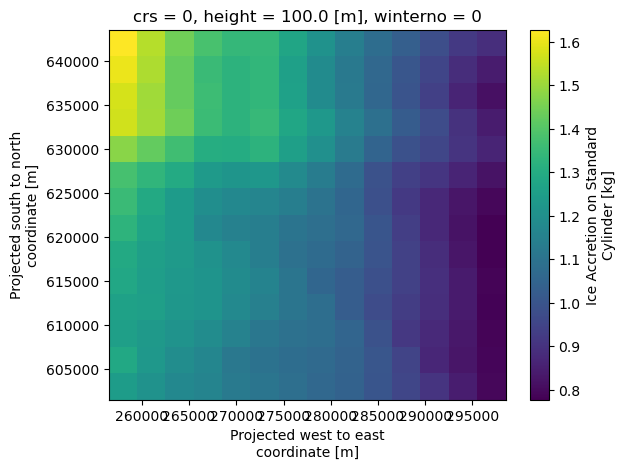

In [6]:
ds1.ACCRE_CYL.isel(height=0).groupby('winterno').sum(dim='time').isel(winterno=0).plot()

Caluclate ice load

In [ ]:
dsiceload = xr.zeros_like(ds1['ACCRE_CYL'].isel(height=0)) * np.nan
for idate,date in enumerate(dates[:-1]):
    print(date,dates[idate+1]-pd.to_timedelta('30min'))
    load = ice_load(ds1['ACCRE_CYL'].isel(height=0).sel(time=slice(date,dates[idate+1]-pd.to_timedelta('30min'))).load(),\
                    ds1['ABLAT_CYL'].isel(height=0).sel(time=slice(date,dates[idate+1]-pd.to_timedelta('30min'))).load(),5)
    dsiceload.loc[{'time':load.time}] = load

2018-07-01 00:00:00 2019-06-30 23:30:00
1 17520
2 17520
3 17520
4 17520
5 17520
6 17520
7 17520
8 17520
9 17520
10 17520
11 17520
12 17520
13 17520
14 17520
15 17520
16 17520
17 17520
18 17520
19 17520
20 17520
21 17520
22 17520
23 17520
24 17520
25 17520
26 17520
27 17520
28 17520
29 17520
30 17520
31 17520
32 17520
33 17520
34 17520
35 17520
36 17520
37 17520
38 17520
39 17520
40 17520
41 17520
42 17520
43 17520
44 17520
45 17520
46 17520
47 17520
48 17520
49 17520
50 17520
51 17520
52 17520
53 17520
54 17520
55 17520
56 17520
57 17520
58 17520
59 17520
60 17520
61 17520
62 17520
63 17520
64 17520
65 17520
66 17520
67 17520
68 17520
69 17520
70 17520
71 17520
72 17520
73 17520
74 17520
75 17520
76 17520
77 17520
78 17520
79 17520
80 17520
81 17520
82 17520
83 17520
84 17520
85 17520
86 17520
87 17520
88 17520
89 17520
90 17520
91 17520
92 17520
93 17520
94 17520
95 17520
96 17520
97 17520
98 17520
99 17520
100 17520
101 17520
102 17520
103 17520
104 17520
105 17520
106 17520
107 1752

Merge

In [ ]:
ds1 = xr.merge([ds1, dsiceload.rename('ice_load')])